<a href="https://colab.research.google.com/github/RicardoFagundes123/PortfolioAllocation/blob/main/TCC_PortfolioAllocation_ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## install finrl library
!pip install plotly==4.4.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!pip install PyPortfolioOpt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.3 MB 2.4 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=e2a5166a0e53aeb05a52a9bccd4f0454656e64fa3fbd18e1b07434f7035daa45
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0
--2022-09-28 00:30:32--  https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/99037241/9dc3a580-286a-11e9-8a21-4312b

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 2.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [ ]:
import os
from finrl import config
from finrl import config_tickers

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [ ]:
top_10 = ["VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA", "PETR3.SA", "B3SA3.SA", "ABEV3.SA", "JBSS3.SA", "BBAS3.SA", "WEGE3.SA"]
top_20 = ["ITSA4.SA", "RENT3.SA", "GGBR4.SA", "CSAN3.SA", "LREN3.SA", "BBDC3.SA", "RADL3.SA", "VIVT3.SA", "ENEV3.SA", "TOTS3.SA"]
weights = [15.583, 6.864, 5.662, 4.606, 4.493, 3.953, 3.157, 2.425, 2.343, 2.219,
           2.165, 1.555, 1.524, 1.221, 1.153,
           1.123, 1.113, 1.091, 0.856, 0.825]
tickers = top_10 + top_20
sum = 0
for i in weights:
  sum+=i
sum

63.931

In [ ]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2022-06-30',
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

Successfully added technical indicators


In [ ]:
len(tickers)

20

In [ ]:
train = data_split(df, '2008-01-01','2020-12-31')

In [ ]:
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
feature_dimension = len(tech_indicator_list)
print(f"Feature Dimension: {feature_dimension}")

Feature Dimension: 4


## Machine Learning Models

We trained the machine learning models with technical indicators: MACD, RSI, CCI, DX

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
import torch
%matplotlib inline
import plotly.express as px

trade = data_split(df,'2021-01-01', '2022-06-30')
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor 

def prepare_data(trainData):
  train_date = sorted(set(trainData.date.values))
  X = []
  for i in range(0, len(train_date) - 1):
    d = train_date[i]
    d_next = train_date[i+1]
    y = train.loc[train['date'] == d_next].return_list.iloc[0].loc[d_next].reset_index()
    y.columns = ['tic', 'return']
    x = train.loc[train['date'] == d][['tic','macd','rsi_30','cci_30','dx_30']]
    train_piece = pd.merge(x, y, on = 'tic')
    train_piece['date'] = [d] * len(train_piece)
    X += [train_piece]
  trainDataML = pd.concat(X)
  X = trainDataML[tech_indicator_list].values
  Y = trainDataML[['return']].values

  return X, Y

train_X, train_Y = prepare_data(train)

In [ ]:
train_X

array([[ 1.56402149e-02,  5.02895064e+01,  3.97072111e+01,
         3.31521115e+00],
       [ 4.95127229e-02,  4.98361022e+01,  6.52206209e+01,
         2.05238835e+01],
       [ 2.00134299e-02,  4.95371665e+01,  6.75651772e+01,
         6.07736010e-01],
       ...,
       [ 3.32178666e+00,  7.22841539e+01,  8.39081710e+01,
         3.79251439e+01],
       [ 3.26655949e-01,  5.29298587e+01,  3.68631303e+01,
         1.32245731e+01],
       [-3.29301170e-01,  5.16739576e+01,  1.76494025e+00,
         1.03131272e+00]])

In [ ]:
train_Y

array([[ 0.00945647],
       [-0.02284274],
       [ 0.00762275],
       ...,
       [ 0.00436435],
       [ 0.02876137],
       [ 0.00785091]])

In [ ]:
rf_model = RandomForestRegressor(max_depth = 35,  min_samples_split = 10, random_state = 0).fit(train_X, train_Y.reshape(-1))
dt_model = DecisionTreeRegressor(random_state = 0, max_depth=35, min_samples_split = 10 ).fit(train_X, train_Y.reshape(-1))
svm_model =  SVR(epsilon=0.14).fit(train_X, train_Y.reshape(-1))
lr_model = LinearRegression().fit(train_X, train_Y)

In [ ]:
def output_predict(model, reference_model = False):
  meta_coefficient = {"date":[], "weights":[]}

  portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
  initial_capital = 1000000
  portfolio.loc[0,unique_trade_date[0]] = initial_capital

  for i in range(len(unique_trade_date) - 1):
      
      current_date = unique_trade_date[i]
      next_date = unique_trade_date[i+1]
      df_current = df[df.date==current_date].reset_index(drop=True)
      tics = df_current['tic'].values
      features = df_current[tech_indicator_list].values
      df_next = df[df.date==next_date].reset_index(drop=True)
      if not reference_model:
        predicted_y = model.predict(features)      
        mu = predicted_y
        Sigma = risk_models.sample_cov(df_current.return_list[0], returns_data=True)
      else:
        mu = df_next.return_list[0].loc[next_date].values
        Sigma = risk_models.sample_cov(df_next.return_list[0], returns_data=True)
      predicted_y_df = pd.DataFrame({"tic":tics.reshape(-1,), "predicted_y":mu.reshape(-1,)})
      min_weight, max_weight = 0, 1
      ef = EfficientFrontier(mu, Sigma)
      weights = ef.nonconvex_objective(
          objective_functions.sharpe_ratio,
          objective_args=(ef.expected_returns, ef.cov_matrix),
          weights_sum_to_one=True,
          constraints=[
              {"type": "ineq", "fun": lambda w: w - min_weight},  # greater than min_weight
              {"type": "ineq", "fun": lambda w: max_weight - w},  # less than max_weight
          ],
      )
      
      weight_df = {"tic":[], "weight":[]}
      meta_coefficient["date"] += [current_date]
      # it = 0
      for item in weights:
        weight_df['tic'] += [item]
        weight_df['weight'] += [weights[item]]
      
      weight_df = pd.DataFrame(weight_df).merge(predicted_y_df, on = ['tic'])
      meta_coefficient["weights"] += [weight_df]
      cap = portfolio.iloc[0, i]
      #current cash invested for each stock
      current_cash = [element * cap for element in list(weights.values())]
      # current held shares
      current_shares = list(np.array(current_cash) / np.array(df_current.close))
      # next time period price
      next_price = np.array(df_next.close)
      portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
      
  portfolio=portfolio.T
  portfolio.columns = ['account_value']
  portfolio = portfolio.reset_index()
  portfolio.columns = ['date', 'account_value']
  stats = backtest_stats(portfolio, value_col_name = 'account_value')
  portfolio_cumprod =(portfolio.account_value.pct_change()+1).cumprod()-1

  return portfolio, stats, portfolio_cumprod, pd.DataFrame(meta_coefficient)

lr_portfolio, lr_stats, lr_cumprod, lr_weights = output_predict(lr_model)
dt_portfolio, dt_stats, dt_cumprod, dt_weights = output_predict(dt_model)
svm_portfolio, svm_stats, svm_cumprod, svm_weights = output_predict(svm_model)
rf_portfolio, rf_stats, rf_cumprod, rf_weights = output_predict(rf_model)
reference_portfolio, reference_stats, reference_cumprod, reference_weights = output_predict(None, True)

Annual return          0.240399
Cumulative returns     0.372055
Annual volatility      0.430062
Sharpe ratio           0.721640
Calmar ratio           0.713834
Stability              0.811281
Max drawdown          -0.336771
Omega ratio            1.138374
Sortino ratio          1.008785
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.030415
Daily value at risk   -0.052951
dtype: float64
Annual return          0.106163
Cumulative returns     0.159678
Annual volatility      0.349392
Sharpe ratio           0.463238
Calmar ratio           0.351571
Stability              0.396132
Max drawdown          -0.301966
Omega ratio            1.079023
Sortino ratio          0.702249
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.282420
Daily value at risk   -0.043377
dtype: float64
Annual return         -0.419494
Cumulative returns    -0.550004
Annual volatility      0.357637
Sharpe ratio          -1.344157
Calmar rat

In [ ]:
import pyfolio
%matplotlib inline
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

baseline_df = get_baseline(
        ticker="^BVSP", 
        start = '2021-01-01',
        end =  '2022-06-30')

baseline_df_stats = backtest_stats(baseline_df, value_col_name = 'close')
baseline_returns = get_daily_return(baseline_df, value_col_name="close")

bvsp_cumpod =(baseline_returns+1).cumprod()-1

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (370, 8)
Annual return         -0.111767
Cumulative returns    -0.159719
Annual volatility      0.202773
Sharpe ratio          -0.484367
Calmar ratio          -0.447041
Stability              0.354520
Max drawdown          -0.250015
Omega ratio            0.925126
Sortino ratio         -0.634960
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.788913
Daily value at risk   -0.025937
dtype: float64


In [ ]:
lr_weights

,date,weights
0,2021-01-04,tic weight predicted_y 0 AB...
1,2021-01-05,tic weight predicted_y 0 AB...
2,2021-01-06,tic weight predicted_y 0 AB...
3,2021-01-07,tic weight predicted_y 0 AB...
4,2021-01-08,tic weight predicted_y 0 AB...
...,...,...
364,2022-06-22,tic weight predicted_y 0 AB...
365,2022-06-23,tic weight predicted_y 0 AB...
366,2022-06-24,tic weight predicted_y 0 AB...
367,2022-06-27,tic weight predicted_y 0 AB...


### PLOT

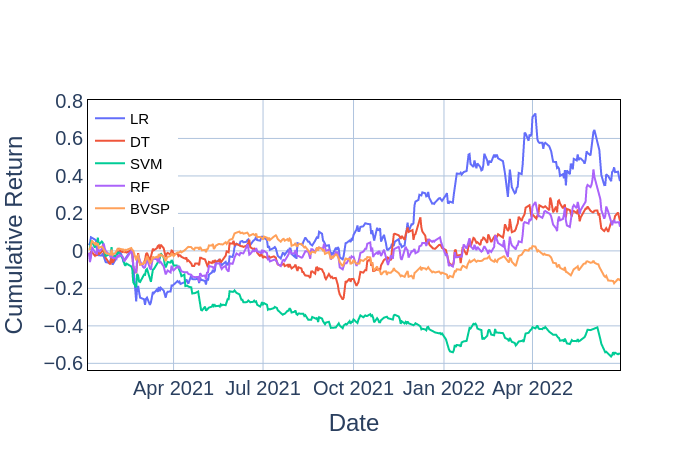

In [ ]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
time_ind = pd.Series(lr_portfolio.date)
trace1_portfolio = go.Scatter(x = time_ind, y = lr_cumprod, mode = 'lines', name = 'LR')
trace2_portfolio = go.Scatter(x = time_ind, y = dt_cumprod, mode = 'lines', name = 'DT')
trace3_portfolio = go.Scatter(x = time_ind, y = svm_cumprod, mode = 'lines', name = 'SVM')
trace4_portfolio = go.Scatter(x = time_ind, y = rf_cumprod, mode = 'lines', name = 'RF')
trace5_portfolio = go.Scatter(x = time_ind, y = bvsp_cumpod, mode = 'lines', name = 'BVSP')

fig = go.Figure()
fig.add_trace(trace1_portfolio)
fig.add_trace(trace2_portfolio)
fig.add_trace(trace3_portfolio)
fig.add_trace(trace4_portfolio)
fig.add_trace(trace5_portfolio)

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
fig.update_layout(
    title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.update_layout(
    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    xaxis_title="Date",
    yaxis = dict(titlefont = dict(size = 30), title = "Cumulative Return"),
    font=dict(
        size=40,
    ),
)
fig.update_layout(font_size = 20)
fig.update_traces(line=dict(width=2))

fig.update_xaxes(showline=True, linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show("png")

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

In [ ]:
lr_portfolio.to_csv("./lr_portfolio_"+now+".csv")
id="1MJJyhpcOor6clgRdemgefhoUA55N6rqp"
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./lr_portfolio_"+now+".csv")
f.Upload()

lr_stats.to_csv("./lr_stats_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./lr_stats_"+now+".csv")
f.Upload()

lr_cumprod.to_csv("./lr_cumprod_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./lr_cumprod_"+now+".csv")
f.Upload()

lr_weights.to_csv("./lr_weights_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./lr_weights_"+now+".csv")
f.Upload()

In [ ]:
lr_portfolio.to_csv("./lr_portfolio_"+now+".csv")
id="1MJJyhpcOor6clgRdemgefhoUA55N6rqp"
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./lr_portfolio_"+now+".csv")
f.Upload()

lr_stats.to_csv("./lr_stats_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./lr_stats_"+now+".csv")
f.Upload()

lr_cumprod.to_csv("./lr_cumprod_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./lr_cumprod_"+now+".csv")
f.Upload()

lr_weights.to_csv("./lr_weights_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./lr_weights_"+now+".csv")
f.Upload()

In [ ]:
dt_portfolio.to_csv("./dt_portfolio_"+now+".csv")
id="1pneRMEtdOMdxyWZVGTyLm2BJtSUdkRIN"
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./dt_portfolio_"+now+".csv")
f.Upload()

dt_stats.to_csv("./dt_stats_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./dt_stats_"+now+".csv")
f.Upload()

dt_cumprod.to_csv("./dt_cumprod_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./dt_cumprod_"+now+".csv")
f.Upload()

dt_weights.to_csv("./dt_weights_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./dt_weights_"+now+".csv")
f.Upload()

In [ ]:
svm_portfolio.to_csv("./svm_portfolio_"+now+".csv")
id="1ApF_HbdFOsItQJYmJwBzgQidAW3X4qD3"
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./svm_portfolio_"+now+".csv")
f.Upload()

svm_stats.to_csv("./svm_stats_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./svm_stats_"+now+".csv")
f.Upload()

svm_cumprod.to_csv("./svm_cumprod_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./svm_cumprod_"+now+".csv")
f.Upload()

svm_weights.to_csv("./svm_weights_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./svm_weights_"+now+".csv")
f.Upload()

In [ ]:
rf_portfolio.to_csv("./rf_portfolio_"+now+".csv")
id="1gv3IupwfzSMg5A6_PbYjGiNXZ84rYAIh"
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./rf_portfolio_"+now+".csv")
f.Upload()

rf_stats.to_csv("./rf_stats_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./rf_stats_"+now+".csv")
f.Upload()

rf_cumprod.to_csv("./rf_cumprod_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./rf_cumprod_"+now+".csv")
f.Upload()

rf_weights.to_csv("./rf_weights_"+now+".csv")
f = drive.CreateFile({'parents': [{'id': id}]})
f.SetContentFile("./rf_weights_"+now+".csv")
f.Upload()

### Mean Variance

In [ ]:
%pip install PyPortfolioOpt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [ ]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [ ]:
df.head(20)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-07,3.356233,3.435344,3.356233,2.152090,450505.0,ABEV3.SA,2,0.015640,2.306096,2.016246,50.289506,39.707211,3.315211,2.124930,2.103472,"[[0.0007515573186502416, 0.0005504280172349611...",tic ABEV3.SA BBAS3.SA BBDC3.SA BBDC...
1,2009-01-07,15.890000,15.950000,15.450000,6.737295,1807700.0,BBAS3.SA,2,0.049513,7.317490,5.834770,49.836102,65.220621,20.523884,6.333171,6.295267,"[[0.0007515573186502416, 0.0005504280172349611...",tic ABEV3.SA BBAS3.SA BBDC3.SA BBDC...
2,2009-01-07,6.148923,6.236764,6.052297,3.674327,114751.0,BBDC3.SA,2,0.020013,3.822204,3.376783,49.537166,67.565177,0.607736,3.541581,3.561624,"[[0.0007515573186502416, 0.0005504280172349611...",tic ABEV3.SA BBAS3.SA BBDC3.SA BBDC...
3,2009-01-07,14.166245,14.166245,14.166245,8.325560,0.0,BBDC4.SA,2,-0.131885,9.766125,7.879846,46.060145,-59.291439,16.884492,8.676749,8.652113,"[[0.0007515573186502416, 0.0005504280172349611...",tic ABEV3.SA BBAS3.SA BBDC3.SA BBDC...
4,2009-01-07,2.886189,2.888411,2.741768,1.902518,1879060.0,CSAN3.SA,2,0.065159,1.973218,1.365709,51.174008,183.156277,35.166421,1.630926,1.645879,"[[0.0007515573186502416, 0.0005504280172349611...",tic ABEV3.SA BBAS3.SA BBDC3.SA BBDC...
5,2009-01-07,26.508787,26.508787,25.227619,25.328236,30965.0,ENEV3.SA,2,-0.289891,26.115124,23.823656,37.425169,-44.126720,1.789442,25.493431,25.152326,"[[0.0007515573186502416, 0.0005504280172349611...",tic ABEV3.SA BBAS3.SA BBDC3.SA BBDC...
6,2009-01-07,17.320000,17.700001,17.160000,12.162638,4042600.0,GGBR4.SA,2,-2.169244,25.007135,8.277284,21.695434,-119.807708,56.840228,17.631331,18.564447,"[[0.0007515573186502416, 0.0005504280172349611...",tic ABEV3.SA BBAS3.SA BBDC3.SA BBDC...
7,2009-01-07,4.114551,4.157164,3.963037,2.093010,15003764.0,ITSA4.SA,2,0.022899,2.314289,1.942574,50.856423,34.135706,2.842366,2.071633,1.937073,"[[0.0007515573186502416, 0.0005504280172349611...",tic ABEV3.SA BBAS3.SA BBDC3.SA BBDC...
8,2009-01-07,12.215592,12.356334,11.698157,7.180021,7561102.0,ITUB4.SA,2,0.125928,7.993125,6.413414,51.673079,54.893333,11.837469,6.945571,6.510836,"[[0.0007515573186502416, 0.0005504280172349611...",tic ABEV3.SA BBAS3.SA BBDC3.SA BBDC...
9,2009-01-07,5.140000,5.240000,4.830000,3.744344,4000300.0,JBSS3.SA,2,0.076781,4.546337,3.429502,50.222553,4.493672,12.460107,3.841363,3.294637,"[[0.0007515573186502416, 0.0005504280172349611...",tic ABEV3.SA BBAS3.SA BBDC3.SA BBDC...


In [ ]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

In [ ]:
portfolio.head()


,account_value
2021-01-04,1000000
2021-01-05,1009086.0166
2021-01-06,1007769.636501
2021-01-07,1023061.596933
2021-01-08,1051391.640469


In [ ]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1


In [ ]:
trace1_portfolio = go.Scatter(x = time_ind, y = bvsp_cumpod, mode = 'lines', name = 'BVSP')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')

In [ ]:
fig = go.Figure()

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()